<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

In [ ]:
# Cell 1 — installs (run once at the top)
# !pip install transformers
# (If you need a specific torch build, uncomment & adjust the following)
# %pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 \
#     -f https://download.pytorch.org/whl/torch_stable.html
# %pip install sentencepiece


In [77]:
# Cell 2 — imports & seed setup
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    # …or whatever classes you need
)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set random seeds for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

print(f"Using PyTorch {torch.__version__} on device {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


Using PyTorch 2.7.1+cu126 on device NVIDIA TITAN RTX


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    #
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: NVIDIA TITAN RTX


### Input Parameters


In [ ]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 10
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
# ! git clone https://github.com/crux82/ganbert

In [ ]:

import pandas as pd
df=pd.read_csv("/home/jivnesh/Harshit_Surge/dataset/sampled_train.csv")


In [ ]:
data=pd.DataFrame()
data["models"]=df["model"].apply(lambda x: "ai" if x!= "human" else "human")
data['text']=df['title']+" "+df['generation']

In [ ]:
data.head()

,models,text
0,human,My mom is shaming me for wanting to get off of...
1,ai,DAE feel like their dreams make up memories? A...
2,ai,FBI agent colludes with analyst An FBI agent s...
3,human,Towards the effectiveness of Deep Convolutiona...
4,human,Helen Helen tells the story of a young orphan...


In [17]:
def get_binary_examples(df):
    return list(zip(df["text"], df["models"]))

In [ ]:
examples = get_binary_examples(data)
label_masks = [True] * len(examples)

Load the Tranformer Model

In [72]:
from transformers import AutoModel

transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Function required to load the dataset

Functions required to convert examples into Dataloader

In [18]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Convert the input examples into DataLoader

In [20]:
from sklearn.utils import shuffle

df_human = data[data.models == "human"]
df_ai    = data[data.models =="ai" ]
# 3) Sample for train and test
#   - Train: 10 000 human + 10 000 ai = 20 000
#   - Test :  2 000 human +  2 000 ai =  4 000
train_human = df_human.sample(10000, random_state=42)
train_ai    = df_ai.sample(   10000, random_state=42)
test_human  = df_human.drop(train_human.index).sample(2000, random_state=42)
test_ai     = df_ai   .drop(train_ai   .index).sample(2000, random_state=42)

train_df = pd.concat([train_human, train_ai], axis=0)
test_df  = pd.concat([test_human,  test_ai ], axis=0)
# 4) Shuffle within each split
train_df = shuffle(train_df, random_state=42).reset_index(drop=True)
test_df  = shuffle(test_df,  random_state=42).reset_index(drop=True)
label_map = {"human":0, "ai":1}
label_list = ["human","ai"]

In [21]:
train_examples = list(zip(
    train_df["text"].tolist(),
    train_df["models"].tolist()
))

test_examples  = list(zip(
    test_df["text"].tolist(),
    test_df["models"].tolist()
))


# 6) Create masks (all True, since every example is labeled)
train_label_masks = np.ones(len(train_examples), dtype=bool)
test_label_masks  = np.ones(len(test_examples),  dtype=bool)

# 7) Build your DataLoaders
train_dataloader = generate_data_loader(
    train_examples,
    train_label_masks,
    label_map,
    do_shuffle=True,
    balance_label_examples=False
)

test_dataloader = generate_data_loader(
    test_examples,
    test_label_masks,
    label_map,
    do_shuffle=False,
    balance_label_examples=False
)

print(f"→ train: {len(train_examples)} examples ({train_df.models.value_counts().to_dict()})")
print(f"→ test : {len(test_examples)} examples ({test_df.models.value_counts().to_dict()})")


/tmp/ipykernel_3772421/1314345009.py:54: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


→ train: 20000 examples ({'ai': 10000, 'human': 10000})
→ test : 4000 examples ({'human': 2000, 'ai': 2000})


We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [73]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [74]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

True
4
NVIDIA TITAN RTX


In [75]:
import torch
import torch.nn as nn
from transformers import AutoConfig

# # Check CUDA availability and set up devices
# if not torch.cuda.is_available():
#     raise RuntimeError("CUDA is not available")

# # Set up device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# print(f"Available GPUs: {n_gpu}")

# Get transformer config
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)

# Define hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

# Instantiate models
generator = Generator(
    noise_size=noise_size, 
    output_size=hidden_size, 
    hidden_sizes=hidden_levels_g, 
    dropout_rate=out_dropout_rate
)

discriminator = Discriminator(
    input_size=hidden_size, 
    hidden_sizes=hidden_levels_d, 
    num_labels=len(label_list), 
    dropout_rate=out_dropout_rate
)

# # Move models to primary device first
# transformer = transformer.to(device)
# generator = generator.to(device)
# discriminator = discriminator.to(device)

# # Apply DataParallel for multi-GPU training
# if n_gpu > 1:
#     print(f"Using {n_gpu} GPUs for training")
#     transformer = nn.DataParallel(transformer)
#     generator = nn.DataParallel(generator) 
#     discriminator = nn.DataParallel(discriminator)


In [76]:
import torch
import torch.nn as nn

# Setup device configuration - ALWAYS use cuda:0 as primary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print(f"Using device: {device}")
print(f"Available GPUs: {n_gpu}")

# Move ALL models to the PRIMARY device first
transformer = transformer.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

# Apply DataParallel to ALL models consistently
if n_gpu > 1:
    print(f"Using DataParallel with {n_gpu} GPUs")
    transformer = nn.DataParallel(transformer)
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    
# Model parameters for optimizers (handle DataParallel)
if n_gpu > 1:
    transformer_vars = list(transformer.module.parameters())
    d_vars = transformer_vars + list(discriminator.module.parameters())
    g_vars = list(generator.module.parameters())
else:
    transformer_vars = list(transformer.parameters())
    d_vars = transformer_vars + list(discriminator.parameters())
    g_vars = list(generator.parameters())

# Create optimizers
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)


Using device: cuda:0
Available GPUs: 4
Using DataParallel with 4 GPUs


Let's go with the training procedure

In [ ]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
# transformer_vars = [i for i in transformer.parameters()]
# d_vars = transformer_vars + [v for v in discriminator.parameters()]
# g_vars = [v for v in generator.parameters()]

# #optimizer
# dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
# gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

# #scheduler
# if apply_scheduler:
#   num_train_examples = len(train_examples)
#   num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
#   num_warmup_steps = int(num_train_steps * warmup_proportion)

#   scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)
#   scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)
num_train_epochs = 20
# For each epoch...
for epoch_i in range(0, num_train_epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    
    # Set training mode
    transformer.train()
    generator.train()
    discriminator.train()
    
    tr_g_loss = 0
    tr_d_loss = 0
    t0 = time.time()
    
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move ALL batch data to PRIMARY device (cuda:0)
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)
        b_label_mask = batch[3].to(device, non_blocking=True)

        real_batch_size = b_input_ids.shape[0]
        
        # Clear gradients
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        # Forward pass through transformer
        # DataParallel automatically handles device distribution
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate noise on PRIMARY device
        noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        gen_rep = generator(noise)

        # Concatenate - both tensors should be on same device after DataParallel
        discriminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        features, logits, probs = discriminator(discriminator_input)

        # Rest of your loss calculation and optimization code...
        # (Keep the same loss calculation logic you have)


        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.

    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))
            
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels_ids, all_preds, target_names=label_list, zero_division=0))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels_ids, all_preds))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

======== Epoch 1 / 10 ========


  Batch    10  of    313.    Elapsed: 0:00:04.
  Batch    20  of    313.    Elapsed: 0:00:08.
  Batch    30  of    313.    Elapsed: 0:00:12.
  Batch    40  of    313.    Elapsed: 0:00:16.
  Batch    50  of    313.    Elapsed: 0:00:20.
  Batch    60  of    313.    Elapsed: 0:00:23.
  Batch    70  of    313.    Elapsed: 0:00:27.
  Batch    80  of    313.    Elapsed: 0:00:31.
  Batch    90  of    313.    Elapsed: 0:00:35.
  Batch   100  of    313.    Elapsed: 0:00:39.
  Batch   110  of    313.    Elapsed: 0:00:43.
  Batch   120  of    313.    Elapsed: 0:00:46.
  Batch   130  of    313.    Elapsed: 0:00:50.
  Batch   140  of    313.    Elapsed: 0:00:54.
  Batch   150  of    313.    Elapsed: 0:00:58.
  Batch   160  of    313.    Elapsed: 0:01:01.
  Batch   170  of    313.    Elapsed: 0:01:05.
  Batch   180  of    313.    Elapsed: 0:01:09.
  Batch   190  of    313.    Elapsed: 0:01:13.
  Batch   200  of    313.    Elapsed: 0:01:17.
  Batch   210  of    313.    Elapsed: 0:01:21.
  Batch   220

In [56]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))            

{'epoch': 1, 'Training Loss generator': 0.7080368652892189, 'Training Loss discriminator': 1.0091265285738742, 'Valid. Loss': 0.22438304126262665, 'Valid. Accur.': np.float64(0.92025), 'Training Time': '0:02:00', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.700348071206492, 'Training Loss discriminator': 0.8176187507260722, 'Valid. Loss': 0.20562304556369781, 'Valid. Accur.': np.float64(0.93225), 'Training Time': '0:02:05', 'Test Time': '0:00:07'}
{'epoch': 3, 'Training Loss generator': 0.6986279137218341, 'Training Loss discriminator': 0.7702838744218357, 'Valid. Loss': 0.38024967908859253, 'Valid. Accur.': np.float64(0.89925), 'Training Time': '0:02:11', 'Test Time': '0:00:07'}
{'epoch': 4, 'Training Loss generator': 0.6983037029211514, 'Training Loss discriminator': 0.7514471847790117, 'Valid. Loss': 0.2948113679885864, 'Valid. Accur.': np.float64(0.926), 'Training Time': '0:02:14', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.69742145972510

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel

# Setup device - SINGLE GPU ONLY, no DataParallel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using single device: {device}")

# COMPLETELY FRESH transformer - replace with your actual model name
# Based on your GAN training, this should be the same model you used successfully
# model_name = "roberta-base"  # Replace with your actual model name from successful GAN training
transformer = AutoModel.from_pretrained(model_name)
transformer = transformer.to(device)

print(f"Fresh transformer type: {type(transformer)}")
print(f"Has config: {hasattr(transformer, 'config')}")

# Get config and setup
config = transformer.config
hidden_size = config.hidden_size
num_labels = len(label_list)

print(f"Hidden size: {hidden_size}")
print(f"Number of labels: {num_labels}")

# Clean classifier implementation with proper pooling
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model, hidden_size, num_labels, dropout_rate=0.1):
        super(TransformerClassifier, self).__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        # Get transformer outputs
        transformer_outputs = self.transformer(input_ids, attention_mask=attention_mask)
        hidden_states = transformer_outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Mean pooling with attention mask
        if attention_mask is not None:
            # Expand mask to match hidden states dimensions
            mask_expanded = attention_mask.unsqueeze(-1).expand_as(hidden_states).float()
            # Apply mask and compute mean
            sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            pooled_output = sum_embeddings / sum_mask
        else:
            # Simple mean pooling if no mask
            pooled_output = torch.mean(hidden_states, dim=1)
        
        # Classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Create classifier - SINGLE GPU, NO DataParallel
classifier_model = TransformerClassifier(
    transformer_model=transformer,
    hidden_size=hidden_size,
    num_labels=num_labels,
    dropout_rate=0.1
).to(device)

print(f"Classifier created successfully on {device}")

# Setup training - SINGLE GPU
optimizer = torch.optim.AdamW(classifier_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# Learning rate scheduler
if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)
    
    from transformers import get_constant_schedule_with_warmup
    scheduler = get_constant_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps
    )

print("Starting baseline transformer training...")

# Training statistics
training_stats = []
total_t0 = time.time()

# Training loop
for epoch_i in range(0, num_train_epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    successful_batches = 0
    classifier_model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # Move batch to device
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = classifier_model(b_input_ids, attention_mask=b_input_mask)
        
        # Calculate loss only for labeled examples
        if b_label_mask.sum() > 0:
            masked_logits = logits[b_label_mask.bool()]
            masked_labels = b_labels[b_label_mask.bool()]
            loss = criterion(masked_logits, masked_labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier_model.parameters(), 1.0)
            optimizer.step()
            
            if apply_scheduler:
                scheduler.step()
            
            total_train_loss += loss.item()
            successful_batches += 1
        else:
            continue
    
    # Calculate average training loss
    if successful_batches > 0:
        avg_train_loss = total_train_loss / successful_batches
        training_time = format_time(time.time() - t0)
        
        print(f"  Average training loss: {avg_train_loss:.3f}")
        print(f"  Training epoch took: {training_time}")
        
        # ========================================
        #               Evaluation
        # ========================================
        print("Running Evaluation...")
        
        t0 = time.time()
        classifier_model.eval()
        
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        all_preds = []
        all_labels = []
        
        # Evaluate on test set
        for batch in test_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():
                logits = classifier_model(b_input_ids, attention_mask=b_input_mask)
                loss = criterion(logits, b_labels)
                
                # Calculate predictions
                predictions = torch.argmax(logits, dim=-1)
                
                # Move to CPU for metric calculation
                predictions = predictions.detach().cpu().numpy()
                labels = b_labels.detach().cpu().numpy()
                
                # Store predictions and labels
                all_preds.extend(predictions)
                all_labels.extend(labels)
                
                # Calculate batch accuracy
                batch_accuracy = accuracy_score(labels, predictions)
                total_eval_accuracy += batch_accuracy
                total_eval_loss += loss.item()
                nb_eval_steps += 1
        
        # Calculate final metrics
        avg_eval_accuracy = total_eval_accuracy / nb_eval_steps
        avg_eval_loss = total_eval_loss / nb_eval_steps
        eval_time = format_time(time.time() - t0)
        
        print(f"  Accuracy: {avg_eval_accuracy:.3f}")
        print(f"  Average evaluation loss: {avg_eval_loss:.3f}")
        print(f"  Evaluation took: {eval_time}")
        
        # Detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=label_list, zero_division=0))
        
        # Confusion Matrix
        print("\nConfusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))
        
        # Record statistics
        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_eval_loss,
            'Valid. Accur.': avg_eval_accuracy,
            'Training Time': training_time,
            'Evaluation Time': eval_time
        })
    else:
        print("No successful training batches this epoch")

print("Training complete!")
print(f"Total training took {format_time(time.time() - total_t0)}")

# Print training statistics
if training_stats:
    import pandas as pd
    df_stats = pd.DataFrame(data=training_stats)
    print("\nTraining Statistics:")
    print(df_stats)
    
    # Compare with your GAN results
    best_baseline_acc = max([stat['Valid. Accur.'] for stat in training_stats])
    print(f"\nBaseline Transformer Best Accuracy: {best_baseline_acc:.3f}")
    print(f"Your GAN Training Best Accuracy: 0.938")
    print(f"GAN Improvement: {0.938 - best_baseline_acc:.3f}")


Using single device: cuda:0


Fresh transformer type: <class 'transformers.models.bert.modeling_bert.BertModel'>
Has config: True
Hidden size: 768
Number of labels: 2
Classifier created successfully on cuda:0
Starting baseline transformer training...
======== Epoch 1 / 10 ========
Training...
  Batch    10  of    313.    Elapsed: 0:00:02.
  Batch    20  of    313.    Elapsed: 0:00:04.
  Batch    30  of    313.    Elapsed: 0:00:06.
  Batch    40  of    313.    Elapsed: 0:00:09.
  Batch    50  of    313.    Elapsed: 0:00:11.
  Batch    60  of    313.    Elapsed: 0:00:13.
  Batch    70  of    313.    Elapsed: 0:00:15.
  Batch    80  of    313.    Elapsed: 0:00:17.
  Batch    90  of    313.    Elapsed: 0:00:20.
  Batch   100  of    313.    Elapsed: 0:00:22.
  Batch   110  of    313.    Elapsed: 0:00:24.
  Batch   120  of    313.    Elapsed: 0:00:27.
  Batch   130  of    313.    Elapsed: 0:00:29.
  Batch   140  of    313.    Elapsed: 0:00:32.
  Batch   150  of    313.    Elapsed: 0:00:34.
  Batch   160  of    313.    El

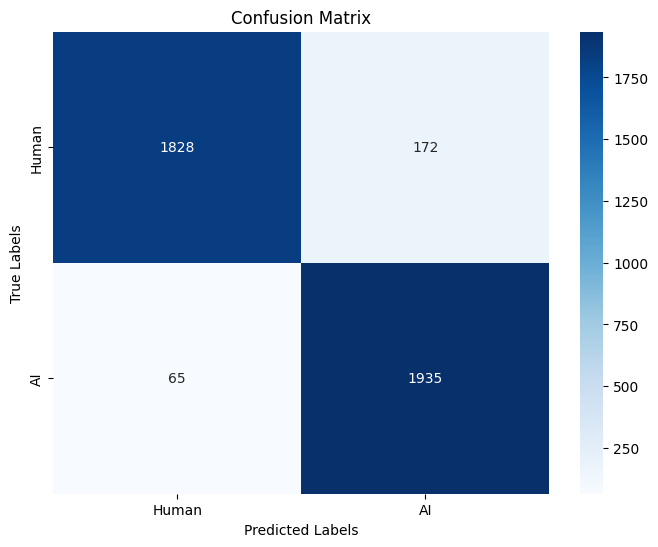

In [11]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Confusion matrix data
conf_matrix = np.array([[1828, 172], [65, 1935]])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])

# Add labels, title, and axis ticks
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data placeholders – replace with your actual metrics
epochs = list(range(1, 11))
training_accuracy = [0.85, 0.90, 0.93, 0.94, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98]
validation_accuracy = [0.91, 0.93, 0.90, 0.90, 0.92, 0.925, 0.924, 0.913, 0.927, 0.941]
training_loss = [0.28, 0.12, 0.07, 0.04, 0.03, 0.02, 0.013, 0.011, 0.010, 0.009]
validation_loss = [0.20, 0.21, 0.44, 0.51, 0.40, 0.39, 0.49, 0.60, 0.53, 0.41]

# Plot Training and Validation Accuracy on the same curve
plt.figure()
plt.plot(epochs, training_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Training vs. Validation Loss per Epoch
plt.figure()
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Combined Accuracy (Training & Validation) on one plot
plt.figure()
plt.plot(epochs, training_accuracy, marker='o', label='Training Acc')
plt.plot(epochs, validation_accuracy, marker='o', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves per Epoch')
plt.legend()
plt.tight_layout()
plt.show()


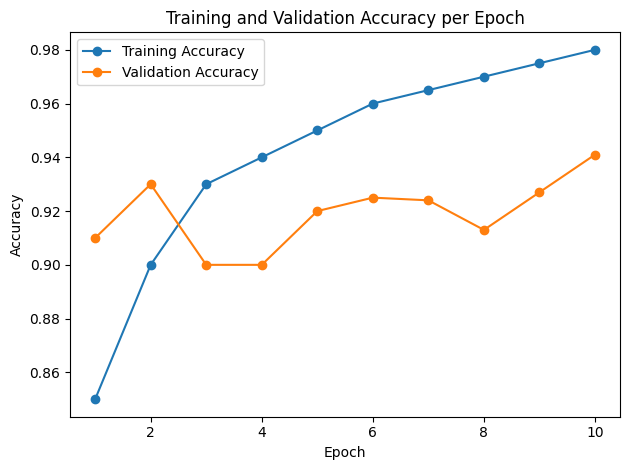

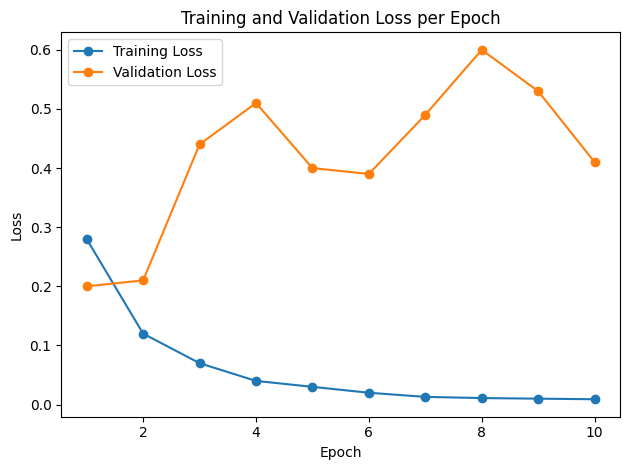

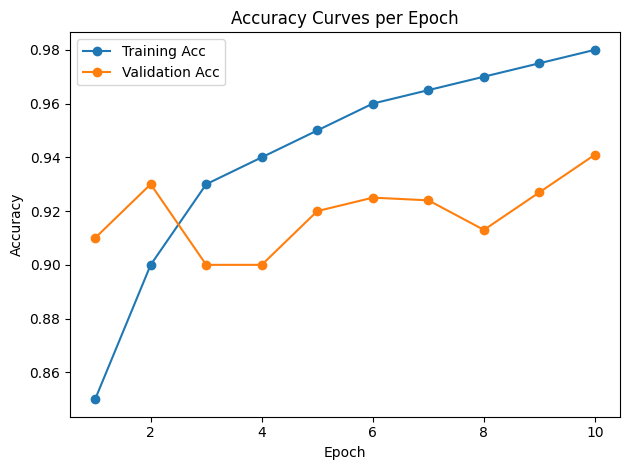

In [13]:
import matplotlib.pyplot as plt

# Example data placeholders – replace with your actual metrics
epochs = list(range(1, 11))
training_accuracy = [0.85, 0.90, 0.93, 0.94, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98]
validation_accuracy = [0.91, 0.93, 0.90, 0.90, 0.92, 0.925, 0.924, 0.913, 0.927, 0.941]
training_loss = [0.28, 0.12, 0.07, 0.04, 0.03, 0.02, 0.013, 0.011, 0.010, 0.009]
validation_loss = [0.20, 0.21, 0.44, 0.51, 0.40, 0.39, 0.49, 0.60, 0.53, 0.41]

# Plot Training and Validation Accuracy on the same curve
plt.figure()
plt.plot(epochs, training_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Training vs. Validation Loss per Epoch
plt.figure()
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Combined Accuracy (Training & Validation) on one plot
plt.figure()
plt.plot(epochs, training_accuracy, marker='o', label='Training Acc')
plt.plot(epochs, validation_accuracy, marker='o', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves per Epoch')
plt.legend()
plt.tight_layout()
plt.show()
